## UE20CS344: Network Analysis and Mining

#### Course Project: Recommender System by Link Prediction using Algorithms and GNN

#### Importing necessary libraries

In [1]:
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import kernighan_lin_bisection, louvain_communities
from networkx.algorithms.community.label_propagation import label_propagation_communities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

#### Miscellaneous functions

In [2]:
def newColorHex():
    color = '#'
    for i in range(6):
        color += np.random.choice(list("6789ABCD"))
    return color

#### Reading CSV files containing relations between people and the products they bought

In [3]:
edgelist_df = pd.read_csv('data/relations.csv')
people_df = pd.read_csv('data/people.csv')
names = people_df.set_index('id').T.to_dict('list')
names = {k: v[0] for k, v in names.items()}


purchases = pd.read_csv('data/purchases.csv')
products = pd.read_csv('data/products.csv').set_index('id').T.to_dict()
product_names = {k: v['product'] for k, v in products.items() if k in purchases['product_id'].unique()}
product_prices = {k: int(v['price']) for k, v in products.items() if k in purchases['product_id'].unique()}

### Plotting relations between people

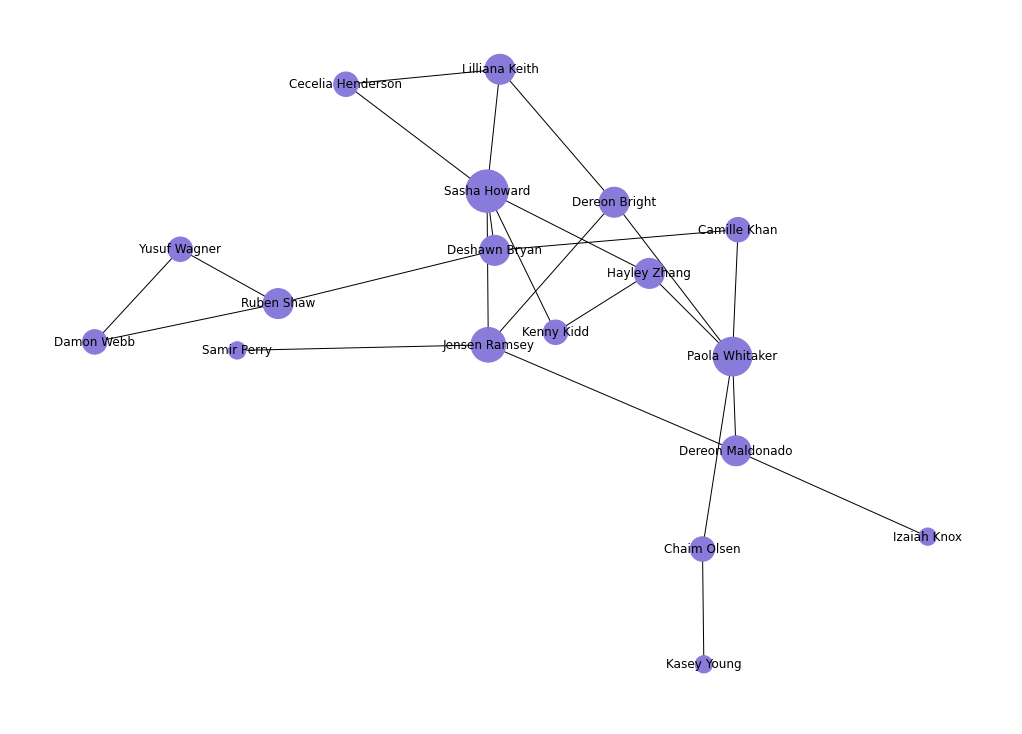

In [4]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
nx.draw(G, pos, node_color=newColorHex(),
        with_labels=True,
        nodelist=d,
        node_size=[d[k]*300 for k in d])

### Finding communities

#### Partitioning the set of people via centraility measures (Girvan-Newman algorithm)

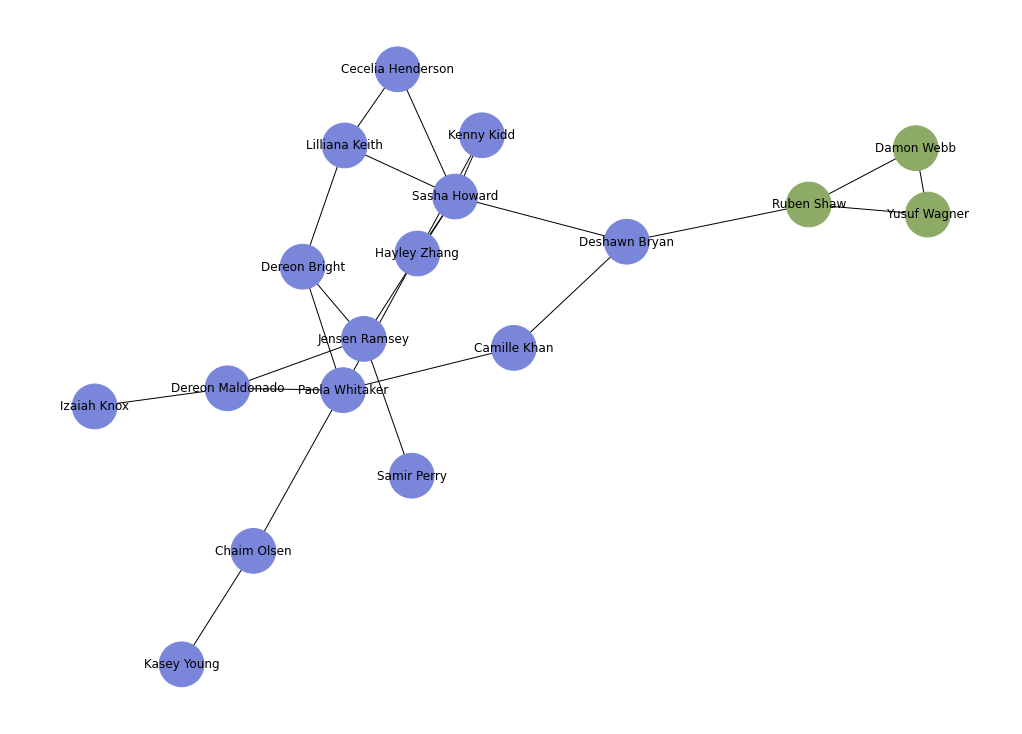

In [5]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = girvan_newman(G)

node_groups = []
for com in next(communities):
    node_groups.append(set(com))

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw(G, node_color=color_map, with_labels=True, node_size=2000)

#### Finding bipartitions (Kernighan-Lin bipartition algorithm)

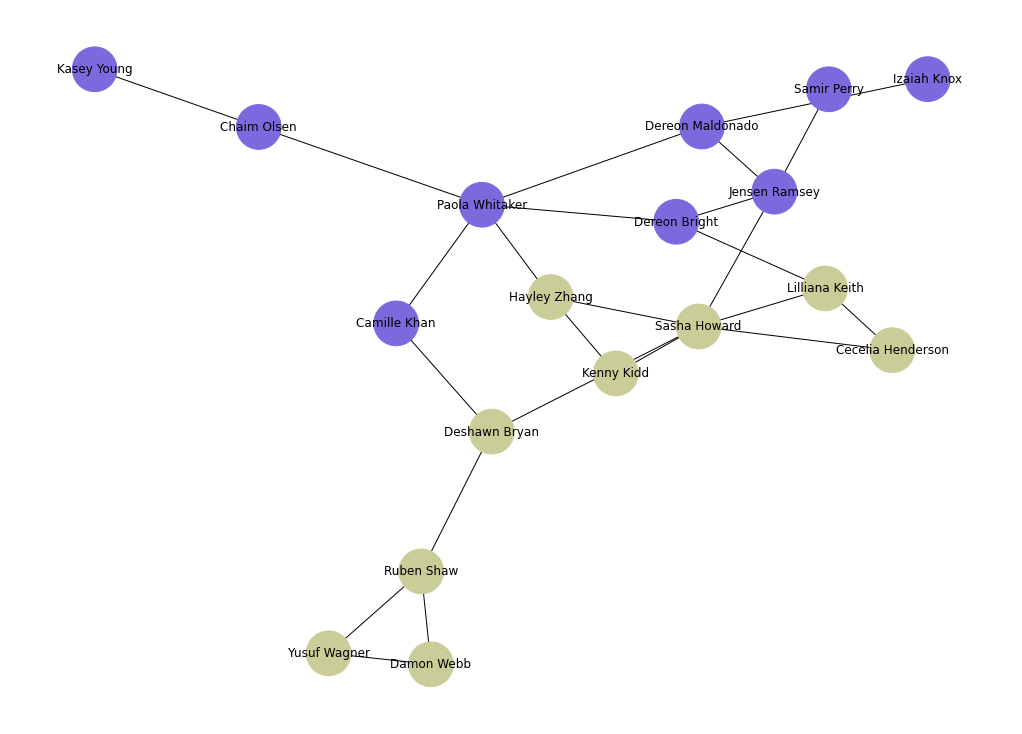

In [6]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = kernighan_lin_bisection(G)

node_groups = []
for com in communities:
    node_groups.append(com)

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw(G, node_color=color_map, with_labels=True, node_size=2000)

#### Finding communities using label propagation community detection algorithm

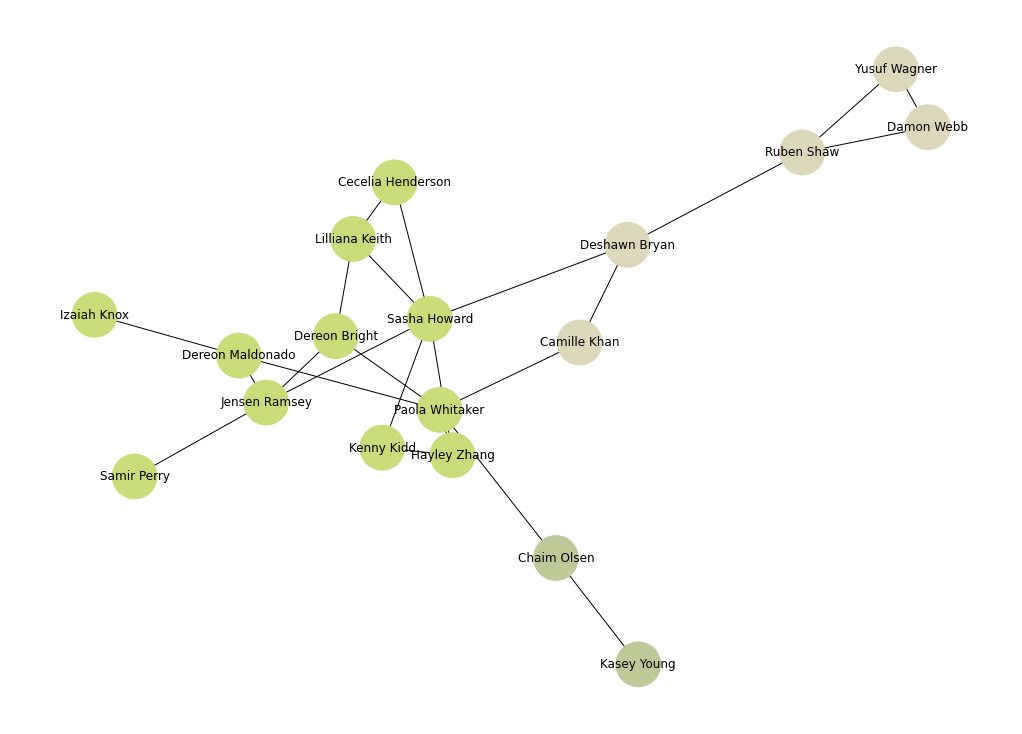

In [7]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = label_propagation_communities(G)

node_groups = []
for com in communities:
    node_groups.append(com)

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw(G, node_color=color_map, with_labels=True, node_size=2000)

#### Detecting communities using the Louvain community detection algorithm

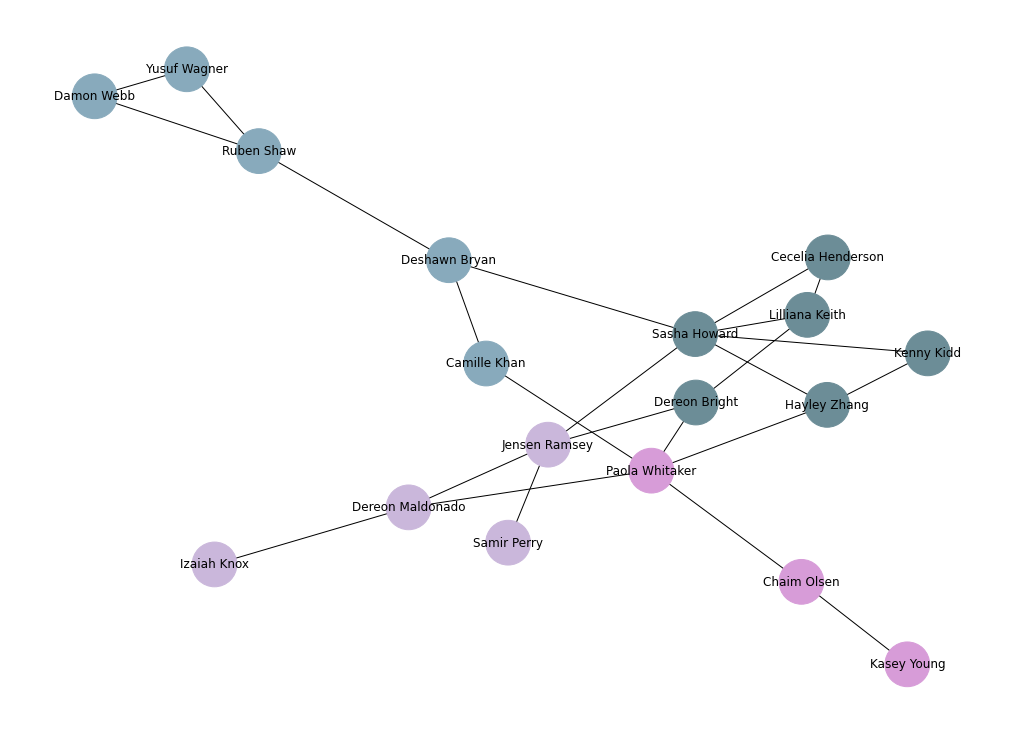

In [8]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edgelist_df, source='id1', target='id2')
G = nx.relabel_nodes(G, names)

communities = louvain_communities(G)

node_groups = []
for com in communities:
    node_groups.append(com)

group_colors = [newColorHex() for _ in node_groups]

color_map = []
for node in G:
    for group_num in range(len(node_groups)):
        if node in node_groups[group_num]:
            color_map.append(group_colors[group_num])

plt.figure(5, figsize=(14, 10))
nx.draw(G, node_color=color_map, with_labels=True, node_size=2000)

### Plotting people and their purchases

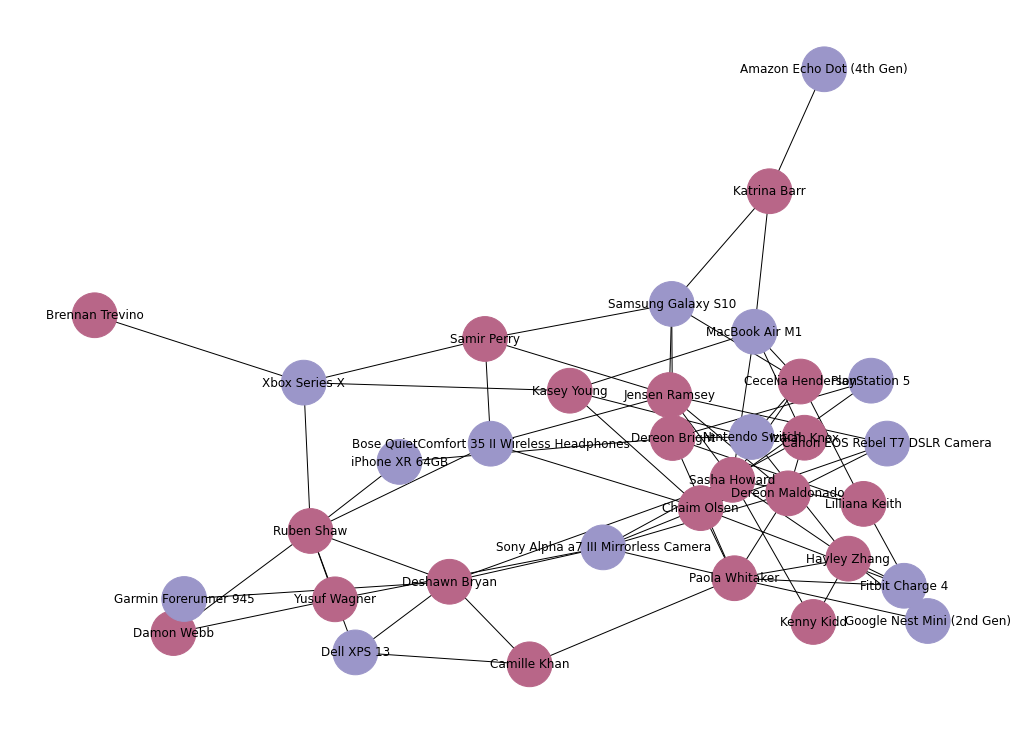

In [9]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

person_nodes = set(people_df.id.tolist())
product_nodes = set(purchases.product_id)

person_color = newColorHex()
product_color = newColorHex()

color_map = []
for node in G:
    if node in person_nodes:
        color_map.append(person_color)
    elif node in product_nodes:
        color_map.append(product_color)

G = nx.relabel_nodes(G, names)
G = nx.relabel_nodes(G, product_names)

plt.figure(5, figsize=(14, 10))
nx.draw(G, node_color=color_map, with_labels=True, node_size=2000)

## Link Prediction using Algorithms

#### Using resource allocation index

In [10]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

iterator_list = list(nx.resource_allocation_index(G, ebunch=ebunch))
iterator_list_sorted = sorted(iterator_list, key=lambda x: x[2], reverse=True)
rai_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), iterator_list_sorted))

df_predictions = pd.DataFrame(rai_predictions, columns=['person', 'product', 'resource_allocation_index'])
df_predictions

,person,product,resource_allocation_index
0,Ruben Shaw,Sony Alpha a7 III Mirrorless Camera,0.500000
1,Sasha Howard,Google Nest Mini (2nd Gen),0.416667
2,Dereon Bright,Google Nest Mini (2nd Gen),0.375000
3,Paola Whitaker,Canon EOS Rebel T7 DSLR Camera,0.366667
4,Sasha Howard,Nintendo Switch,0.366667
...,...,...,...
229,Katrina Barr,iPhone XR 64GB,0.000000
230,Katrina Barr,PlayStation 5,0.000000
231,Katrina Barr,Xbox Series X,0.000000
232,Katrina Barr,Dell XPS 13,0.000000


#### Using Jaccard coefficient

In [11]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

jaccard_coefficients_list = list(nx.jaccard_coefficient(G, ebunch=ebunch))
jaccard_coefficients_sorted = sorted(jaccard_coefficients_list, key=lambda x: x[2], reverse=True)
jaccard_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), jaccard_coefficients_sorted))

df_jaccard_predictions = pd.DataFrame(jaccard_predictions, columns=['person', 'product', 'jaccard_coefficient'])
df_jaccard_predictions

,person,product,jaccard_coefficient
0,Lilliana Keith,PlayStation 5,0.500000
1,Lilliana Keith,Nintendo Switch,0.333333
2,Camille Khan,Garmin Forerunner 945,0.333333
3,Kenny Kidd,PlayStation 5,0.333333
4,Damon Webb,iPhone XR 64GB,0.333333
...,...,...,...
229,Katrina Barr,iPhone XR 64GB,0.000000
230,Katrina Barr,PlayStation 5,0.000000
231,Katrina Barr,Xbox Series X,0.000000
232,Katrina Barr,Dell XPS 13,0.000000


#### Using Adamic-Adar index

In [12]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

iterator_list = list(nx.resource_allocation_index(G, ebunch=ebunch))
iterator_list_sorted = sorted(iterator_list, key=lambda x: x[2], reverse=True)
aai_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), iterator_list_sorted))

df_predictions = pd.DataFrame(aai_predictions, columns=['person', 'product', 'adamic_adar_index'])
df_predictions

,person,product,adamic_adar_index
0,Ruben Shaw,Sony Alpha a7 III Mirrorless Camera,0.500000
1,Sasha Howard,Google Nest Mini (2nd Gen),0.416667
2,Dereon Bright,Google Nest Mini (2nd Gen),0.375000
3,Paola Whitaker,Canon EOS Rebel T7 DSLR Camera,0.366667
4,Sasha Howard,Nintendo Switch,0.366667
...,...,...,...
229,Katrina Barr,iPhone XR 64GB,0.000000
230,Katrina Barr,PlayStation 5,0.000000
231,Katrina Barr,Xbox Series X,0.000000
232,Katrina Barr,Dell XPS 13,0.000000


#### Using common neighbour and centrality based parameterized algorithm score

In [13]:
G = nx.Graph()
G.add_edges_from(edgelist_df.values)
G.add_edges_from(purchases.values)

ebunch = []
for node1 in G:
    for node2 in G:
        if node1 != node2 and (node1, node2) not in G.edges and (node2, node1) not in G.edges:
            if node1 in person_nodes and node2 in product_nodes:
                ebunch.append((node1, node2))

iterator_list = list(nx.common_neighbor_centrality(G, ebunch=ebunch, alpha=0.8)) # default value alpha = 0.8
iterator_list_sorted = sorted(iterator_list, key=lambda x: x[2], reverse=True)
ccpa_predictions = list(map(lambda x: (names[x[0]], product_names[x[1]], x[2]), iterator_list_sorted))

df_predictions = pd.DataFrame(ccpa_predictions, columns=['person', 'product', 'ccpa_score'])
df_predictions

,person,product,ccpa_score
0,Paola Whitaker,Nintendo Switch,5.000000
1,Paola Whitaker,Canon EOS Rebel T7 DSLR Camera,5.000000
2,Lilliana Keith,MacBook Air M1,5.000000
3,Lilliana Keith,Nintendo Switch,5.000000
4,Lilliana Keith,Samsung Galaxy S10,5.000000
...,...,...,...
229,Yusuf Wagner,Amazon Echo Dot (4th Gen),1.360000
230,Brennan Trevino,Google Nest Mini (2nd Gen),1.360000
231,Brennan Trevino,PlayStation 5,1.360000
232,Brennan Trevino,Amazon Echo Dot (4th Gen),1.360000


## Link Prediction using Graph Convolutional Neural Network

#### Importing necessary libraries

In [14]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.data import DGLDataset
from dgl.nn import SAGEConv
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score

#### Creating DGL graph dataset

In [15]:
class GraphDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='shopping')
    
    def process(self):
        nodes_data = pd.DataFrame()
        people_df = pd.read_csv('data/ids_gcn.csv')
        nodes_data['id'] = people_df.id.tolist()

        edges_data = pd.DataFrame()
        relations_df = pd.read_csv('data/relations_gcn.csv')
        edges_data['src'] = relations_df.id1.tolist()
        edges_data['dst'] = relations_df.id2.tolist()

        self.graph = dgl.graph((edges_data.src, edges_data.dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = torch.tensor([1 for _ in range(nodes_data.shape[0])], dtype=torch.float32)
        self.graph.edata['weight'] = torch.tensor([1 for _ in range(edges_data.shape[0])], dtype=torch.float32)

    def __getitem__(self, idx):
        return self.graph
    
    def __len__(self):
        return 1
    
dataset = GraphDataset()
g = dataset[0]

g

Graph(num_nodes=200, num_edges=432,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

#### Preparing training and testing sets

In [16]:
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


In [17]:
train_g = dgl.remove_edges(g, eids[:test_size])

#### Defining a GraphSAGE model

In [18]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

#### Creating positive and negative graphs for the training and testing sets respectively

In [19]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

#### Computing new edge features based on existing node/edge features

Here, we make use of `dgl.function.u_dot_v`, which is a builtin function.

In [20]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score']

#### Adding evaluation metrics

In [21]:
model = GraphSAGE(train_g.ndata['feat'].shape[0], train_g.ndata['feat'].shape[0])
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_acc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return ((scores > 0) == labels).float().sum() / len(labels)

#### Training loop

Optimizer

In [22]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

Training with `compute_loss` as the loss function, which makes use of the area under the receiver operating characteristic curve.

In [23]:
epochs = 1001

losses = []
accs = []

for e in range(epochs):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    acc = compute_acc(pos_score, neg_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 50 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
    
    losses.append(loss.item())
    accs.append(acc.item())

In epoch 0, loss: 2.1234960556030273
In epoch 50, loss: 0.6165367364883423
In epoch 100, loss: 0.46014922857284546
In epoch 150, loss: 0.4324081838130951
In epoch 200, loss: 0.4457269608974457
In epoch 250, loss: 0.429097980260849
In epoch 300, loss: 0.43227916955947876
In epoch 350, loss: 0.4336409866809845
In epoch 400, loss: 0.4281342327594757
In epoch 450, loss: 0.4401993155479431
In epoch 500, loss: 0.4116840064525604
In epoch 550, loss: 0.41597241163253784
In epoch 600, loss: 0.4239920377731323
In epoch 650, loss: 0.4320104420185089
In epoch 700, loss: 0.40506428480148315
In epoch 750, loss: 0.4277874529361725
In epoch 800, loss: 0.4340902268886566
In epoch 850, loss: 0.4153752326965332
In epoch 900, loss: 0.44291263818740845
In epoch 950, loss: 0.4266883432865143
In epoch 1000, loss: 0.41493290662765503


#### Results

In [24]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print(f'Area under ROC: {compute_auc(pos_score, neg_score)}')
    print(f'Accuracy: {compute_acc(pos_score, neg_score)}')

Area under ROC: 0.5105462412114656
Accuracy: 0.5348837375640869


Plotting loss and accuracy against epochs

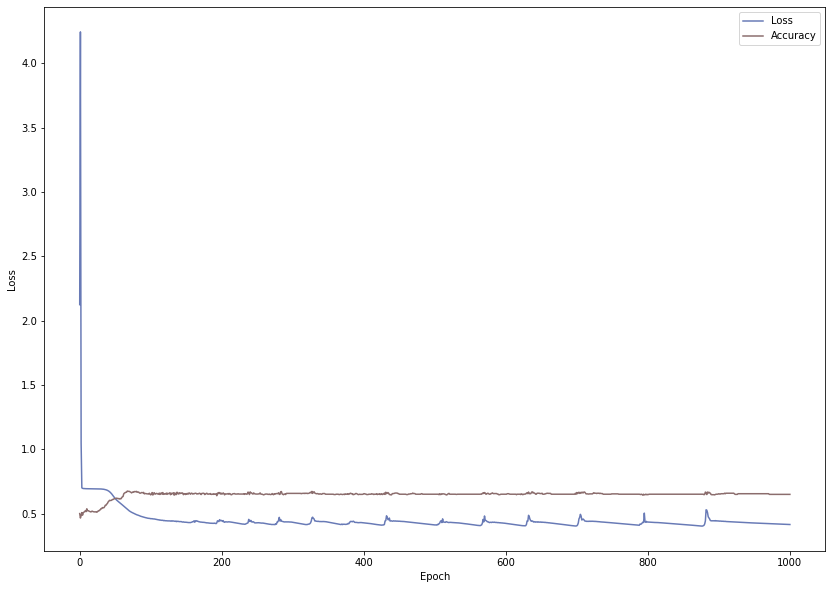

In [25]:
plt.plot(losses, color=newColorHex())
plt.plot(accs, color=newColorHex())
plt.legend(['Loss', 'Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()